In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf



Using TensorFlow backend.


In [31]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'train'
TEST_PATH = 'test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images')]

In [32]:
train_ids

['TCGA-G9-6348-01Z-00-DX1',
 'TCGA-E2-A1B5-01Z-00-DX1',
 'TCGA-CH-5767-01Z-00-DX1',
 'TCGA-AR-A1AS-01Z-00-DX1',
 'TCGA-G9-6336-01Z-00-DX1',
 'TCGA-DK-A2I6-01A-01-TS1',
 'TCGA-A7-A13F-01Z-00-DX1',
 'TCGA-G9-6356-01Z-00-DX1',
 'TCGA-G2-A2EK-01A-02-TSB',
 'TCGA-AY-A8YK-01A-01-TS1',
 'TCGA-38-6178-01Z-00-DX1',
 'TCGA-A7-A13E-01Z-00-DX1',
 'TCGA-G9-6363-01Z-00-DX1',
 'TCGA-21-5786-01Z-00-DX1',
 'TCGA-18-5592-01Z-00-DX1',
 'TCGA-B0-5698-01Z-00-DX1',
 'TCGA-G9-6362-01Z-00-DX1',
 'TCGA-AR-A1AK-01Z-00-DX1',
 'TCGA-B0-5711-01Z-00-DX1',
 'TCGA-50-5931-01Z-00-DX1',
 'TCGA-E2-A14V-01Z-00-DX1',
 'TCGA-21-5784-01Z-00-DX1',
 'TCGA-49-4488-01Z-00-DX1',
 'TCGA-B0-5710-01Z-00-DX1']

In [33]:
test_ids

['TCGA-HE-7130-01Z-00-DX1',
 'TCGA-HE-7128-01Z-00-DX1',
 'TCGA-NH-A8F7-01A-01-TS1',
 'TCGA-HE-7129-01Z-00-DX1',
 'TCGA-KB-A93J-01A-01-TS1',
 'TCGA-RD-A8N9-01A-01-TS1']

In [59]:
from PIL import Image
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH
    img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    mask_ = np.load(path + '/masks/' + id_ + '.npy')
    mask = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                 preserve_range=True), axis=-1)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


  0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2573: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  tile = decompress(tile)
100%|██████████| 24/24 [00:01<00:00, 15.16it/s]


In [60]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH
    img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing test images ... 


100%|██████████| 6/6 [00:00<00:00, 19.85it/s]

Done!


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


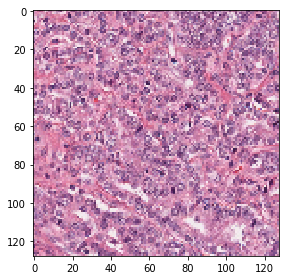

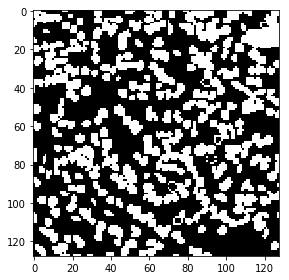

In [61]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [62]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [63]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [70]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 21 samples, validate on 3 samples
Epoch 1/30
21/21 [==============================] - 1s 70ms/step - loss: 0.6175 - mean_iou: 0.3376 - val_loss: 0.5547 - val_mean_iou: 0.3377

Epoch 00001: val_loss improved from inf to 0.55472, saving model to model-1.h5
Epoch 2/30
21/21 [==============================] - 1s 71ms/step - loss: 0.6261 - mean_iou: 0.3377 - val_loss: 0.5632 - val_mean_iou: 0.3377

Epoch 00002: val_loss did not improve from 0.55472
Epoch 3/30
21/21 [==============================] - 1s 65ms/step - loss: 0.6193 - mean_iou: 0.3377 - val_loss: 0.5686 - val_mean_iou: 0.3378

Epoch 00003: val_loss did not improve from 0.55472
Epoch 4/30
21/21 [==============================] - 1s 63ms/step - loss: 0.6183 - mean_iou: 0.3379 - val_loss: 0.5641 - val_mean_iou: 0.3378

Epoch 00004: val_loss did not improve from 0.55472
Epoch 5/30
21/21 [==============================] - 1s 63ms/step - loss: 0.6159 - mean_iou: 0.3380 - val_loss: 0.5716 - val_mean_iou: 0.3381

Epoch 00005: va

In [71]:
# Predict on train, val and test
model = load_model('model-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

6/6 [==============================] - 0s 22ms/step


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


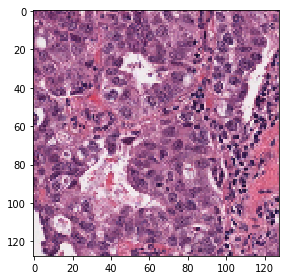

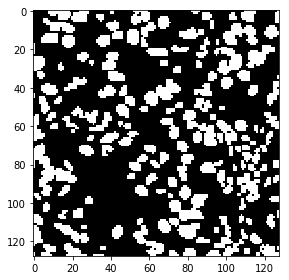

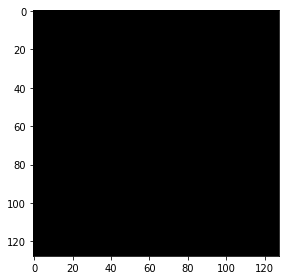

In [72]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


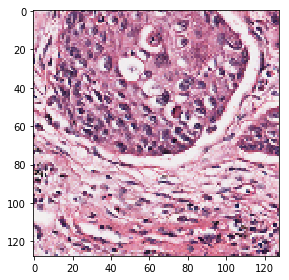

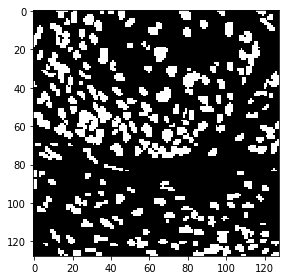

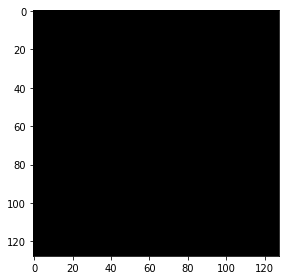

In [73]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()